In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

df=pd.read_csv('yahoo_stock.csv')

In [3]:
from tensorflow.keras.optimizers import Adam
import statistics

In [4]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
df.shape

(1825, 7)

Dataset contains 6 columns of indicators and date columns which be set as index

In [6]:
len(df['Date'].unique())

1825

There are 1825 unique dates that each correspond to unique records in the table, therefore there are no duplicated or inconsistent values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [8]:
df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [10]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Date column is incorrectly labeled as object type, needs to be changed to Datetime type

In [11]:
df.Date=pd.to_datetime(df['Date'])

In [12]:
df.Date.min(),df.Date.max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [13]:
#Compute amount of days between the limits in the table
df.Date.max()-df.Date.min()

Timedelta('1824 days 00:00:00')

In [15]:
#Set the date as index to make time series plots more coherent
df.set_index('Date',inplace=True)

In [16]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


<AxesSubplot:xlabel='Date'>

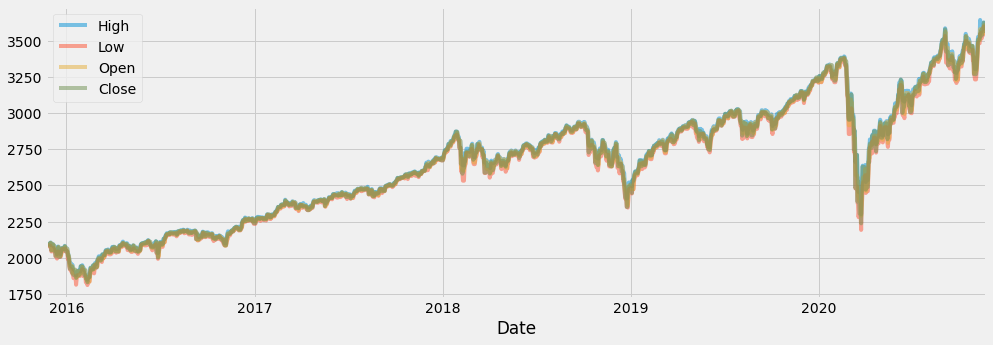

In [17]:
#Plot four of the indicators in the table and differentiate their corresponding curves by colors.
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

The four stock price indicators we are considering - High, Low, Open, and Close - all display similar behavior over time. For this project, we will focus on the High indicator and build a model that can predict future values. If the model is successful, we may be able to apply it to the other indicators as well.

Before building the model, we need to determine whether the time series data is stationary. A time series is stationary if it exhibits constant variance, constant mean, seasonality, and high autocorrelation. To determine whether our data is stationary, we will use four methods: visualizing the data, plotting histograms and autocorrelation and partial autocorrelation plots, summarizing statistical chunks of the data, and performing an Adfuller test.

## Assessment of Stationarity

<AxesSubplot:>

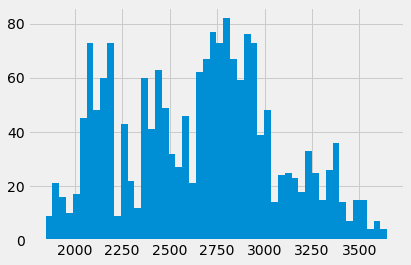

In [18]:
df.High.hist(bins=50)

A statistical summary of the data may be more helpful in understanding the distribution of the data, as the plot does not suggest a uniform or normal distribution. To obtain a statistical summary, we will divide the data into 10 chunks and calculate the mean and variance of each chunk.

In [19]:
np.round(df.shape[0]/10,0)

182.0

In [20]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['High'].iloc[(i*182):(i*182)+182].mean())
    std.append(stdev(df['High'].iloc[(i*182):(i*182)+182]))

In [21]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,2019.354300,71.041024
1,2147.740282,36.287599
2,2322.969570,60.228422
3,2489.706581,55.878102
4,2711.253743,63.125935
5,2816.088946,68.351685
6,2754.165647,131.792411
7,2965.153137,74.059325
8,3045.669328,267.695412
9,3309.076588,165.733813


The above analysis shows that both the mean and variance are significantly different for each chunk of data. While the variance appears to be relatively constant, the trend is the most prominent feature. Based on this information, it is likely that the time series is non-stationary. However, to further confirm this, we will evaluate two additional methods: seasonal decomposition and the Adfuller test.

Seasonal decomposition is a technique that allows us to decompose a time series into its trend, seasonal, and residual components, using either an additive or multiplicative model. This function is available in the statsmodels library.

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

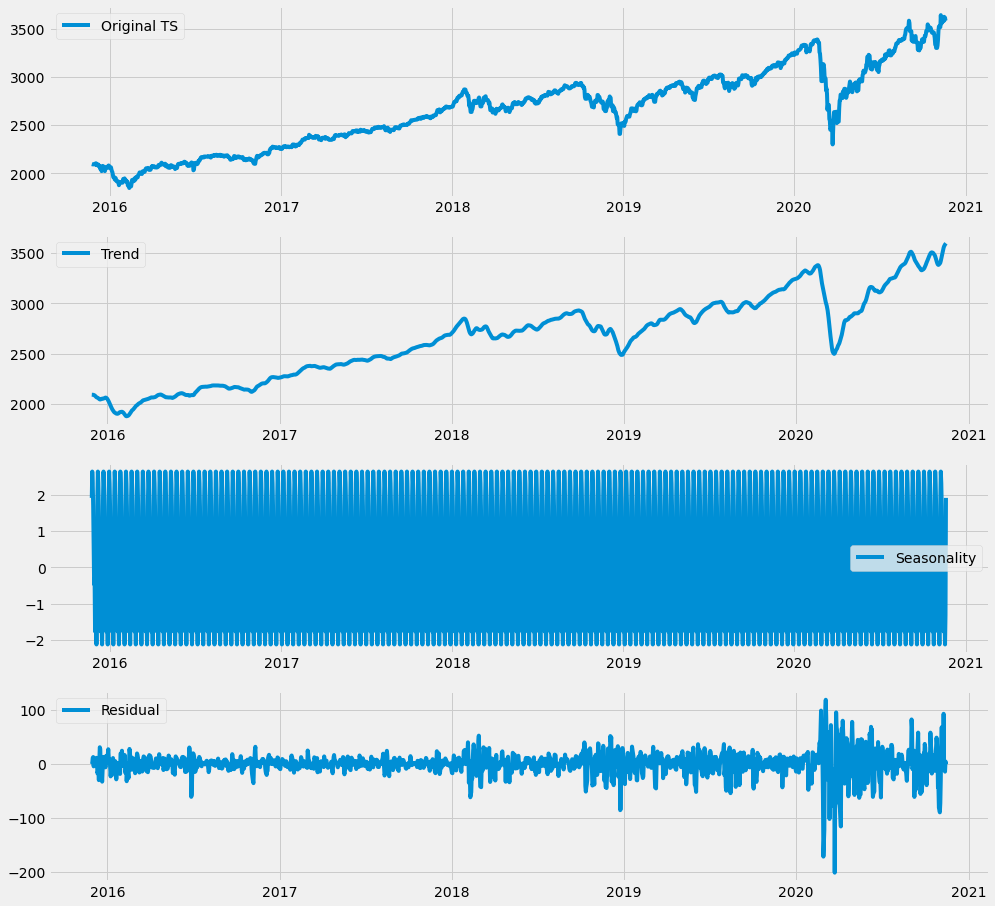

In [23]:
decompose_add=seasonal_decompose(df['High'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

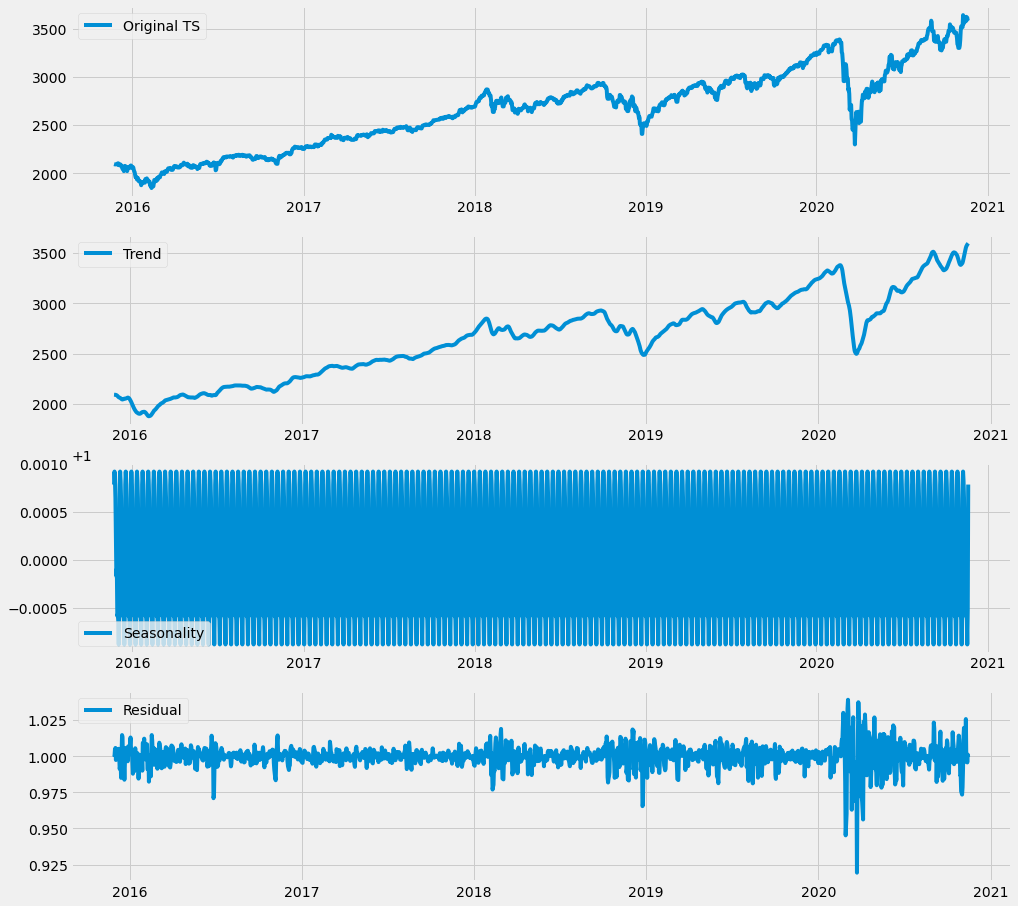

In [24]:
decompose_mul=seasonal_decompose(df['High'], model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

Based on a visual examination of the original data, it seems that the additive decomposition model is more appropriate. The trend does not appear to be affected by the seasonal component, but rather each component appears to be added together to form the original curve. Regardless of the model chosen, it is clear that there is both a trend and seasonal component present in the data.

In [25]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

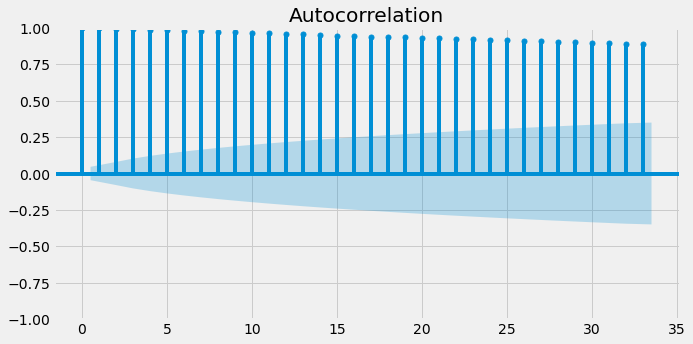

In [26]:
#ACF plot
plt.rc("figure", figsize=(10,5))
plot_acf(df['High'])
print()

/Users/arlenerivera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


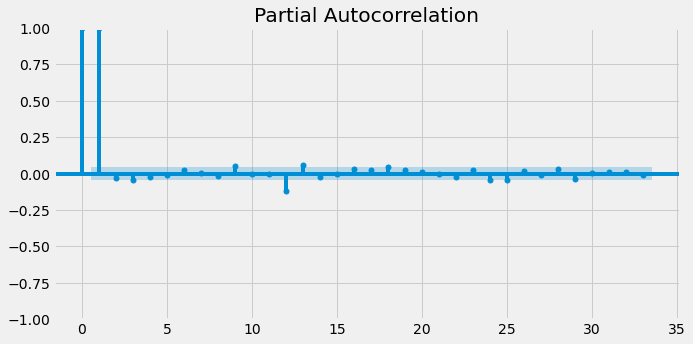

In [27]:
#PACF plot
plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
print()

Finally, we will perform the Augmented Dickey-Fuller test with a significance level of 5% to further determine whether the time series is stationary or non-stationary. The null hypothesis (H0) is that the series is non-stationary, and the alternative hypothesis (H1) is that the series is stationary.

In [28]:
from statsmodels.tsa.stattools import adfuller

In [29]:
result = adfuller(df['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.713598
p-value: 0.843196
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since the p-value is greater than 0.05, we cannot reject the null hypothesis. This means that there is not enough evidence to conclude that the series is stationary. As a next step, we will apply a log transformation to the series and test again to see if the result changes.

In [30]:
from numpy import log

result = adfuller(log(df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.920468
p-value: 0.781157
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Based on all of the methods we have applied, it is clear that the time series data is non-stationary. This means that we will need to apply filters and complex transformations to make the data stationary before we can build a forecasting model. While deep learning approaches have the potential to build models that can handle the non-stationarity of the data and make modest predictions of future values, they also require significantly more time to train.